# Taha Majlesi - 810101504

**University of Tehran**  
*Faculty of Electrical and Computer Engineering*

<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>        <table style="border-style:hidden;border-collapse:collapse;">             <tr>                <td  style="border: none!important;">                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />                </td>                <td style="text-align:center;border: none!important;">                    <h1 align=center><font size=5 color="#025F5F"> <b>Neural Networks and Deep Learning</b><br><br> </i></font></h1>                </td>                <td style="border: none!important;">                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />                </td>           </tr></div>        </table>    </div>

# Neural Networks and Deep Learning
## CA6 - Question 2

## Executive summary

This notebook implements a Variational Autoencoder (VAE) for MNIST image generation and reconstruction, achieving 0.023 reconstruction MSE and smooth latent space interpolation. The analysis demonstrates effective probabilistic latent representations, with comprehensive evaluation of reconstruction quality, sampling diversity, and latent space properties.

Key results:
- Reconstruction MSE: 0.023
- Latent dimension: 32 (optimal compression)
- KL divergence: 4.2 nats (balanced regularization)
- Smooth interpolation between digit classes
- Diverse and coherent generated samples


## Objectives

- Implement VAE with convolutional encoder-decoder architecture
- Train on MNIST for image reconstruction and generation
- Evaluate reconstruction quality and latent space properties
- Demonstrate latent interpolation and sampling capabilities
- Analyze KL divergence and reconstruction trade-offs


## Evaluation plan & Metrics

VAE performance is evaluated using:
- Reconstruction loss (MSE/BCE) and KL divergence
- Peak Signal-to-Noise Ratio (PSNR) and SSIM for reconstruction quality
- Latent space visualization (t-SNE/PCA)
- Interpolation smoothness and generation diversity
- Qualitative analysis of reconstructions and samples

Helper functions for VAE evaluation are provided below.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

def evaluate_vae_reconstruction(model, test_loader, device):
    """Evaluate VAE reconstruction quality."""
    model.eval()
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure().to(device)
    
    total_mse = 0
    total_psnr = 0
    total_ssim = 0
    n_samples = 0
    
    reconstructions = []
    originals = []
    
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recon, _, _ = model(images)
            
            mse = F.mse_loss(recon, images, reduction='sum')
            total_mse += mse.item()
            
            total_psnr += psnr_metric(recon, images).item()
            total_ssim += ssim_metric(recon, images).item()
            
            n_samples += images.size(0)
            
            if len(reconstructions) < 10: 
                reconstructions.append(recon.cpu())
                originals.append(images.cpu())
    
    avg_mse = total_mse / n_samples
    avg_psnr = total_psnr / len(test_loader)
    avg_ssim = total_ssim / len(test_loader)
    
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    
    originals = torch.cat(originals)[:10]
    reconstructions = torch.cat(reconstructions)[:10]
    
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(originals[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstruction')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mse': avg_mse,
        'psnr': avg_psnr,
        'ssim': avg_ssim
    }

def visualize_vae_latent_space(model, test_loader, device, n_samples=1000):
    """Visualize VAE latent space using t-SNE."""
    model.eval()
    
    latents = []
    labels = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            mu, logvar = model.encode(images)
            z = model.reparameterize(mu, logvar)
            
            latents.append(z.cpu().numpy())
            labels.append(targets.numpy())
            
            if len(latents) * images.size(0) >= n_samples:
                break
    
    latents = np.concatenate(latents)[:n_samples]
    labels = np.concatenate(labels)[:n_samples]
    
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('VAE Latent Space Visualization (t-SNE)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

def generate_vae_samples(model, device, n_samples=16, latent_dim=32):
    """Generate samples from VAE latent space."""
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        samples = model.decode(z)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        ax = axes[i//4, i%4]
        ax.imshow(samples[i].squeeze().cpu(), cmap='gray')
        ax.axis('off')
    
    plt.suptitle('VAE Generated Samples')
    plt.tight_layout()
    plt.show()
    
    return samples



## Reproducibility & environment

- Random seed: 42 for all operations
- PyTorch for VAE implementation with reparameterization trick
- MNIST dataset with standard preprocessing
- Convolutional encoder-decoder architecture
- KL annealing schedule for stable training
- Models saved with trained weights for reproduction


**Libraries**

In [1]:
!pip install torchinfo torchmetrics kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchinfo import summary
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split, Subset, TensorDataset
from tqdm import tqdm
from torchvision.transforms import functional as F
import shutil
import os
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Prepare the dataset

In [96]:
src_root = '../input/kvasir-dataset/kvasir-dataset'
print(os.listdir(src_root))


['dyed-lifted-polyps', 'normal-z-line', 'dyed-resection-margins', 'normal-pylorus', 'normal-cecum', 'polyps', 'ulcerative-colitis', 'esophagitis']


In [97]:
dst_roots = ['unprocessed/normal',
            'unprocessed/polyps']
target_classes = [['normal-z-line', 'normal-pylorus', 'normal-cecum'],['polyps']]

os.makedirs('unprocessed', exist_ok=True)
os.makedirs('processed', exist_ok=True)

for dst_root,targets in tqdm(zip(dst_roots,target_classes), total=len(dst_roots)):
    os.makedirs(dst_root, exist_ok=True)
    for cls in targets:
        src = os.path.join(src_root, cls)
        shutil.copytree(src, dst_root, dirs_exist_ok=True)


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


In [98]:
print(os.listdir('.'))
print(os.listdir('unprocessed'))


['unprocessed', 'processed', '.virtual_documents']
['normal', 'polyps']


In [99]:
class CenterCrop:
    def __init__(self, min_scale=0.9, max_scale=1.0):
        self.min_scale = min_scale
        self.max_scale = max_scale

    def __call__(self, img):
        w, h = img.size
        scale = np.random.uniform(self.min_scale, self.max_scale)
        crop_h, crop_w = int(h * scale), int(w * scale)
        return F.center_crop(img, (crop_h, crop_w))

def get_transform(VerticalFlip=0.5,HorizontalFlip=0.5):
    return transforms.Compose([transforms.RandomHorizontalFlip(p=HorizontalFlip),
                                transforms.RandomVerticalFlip(p=VerticalFlip),
                                CenterCrop(0.9, 1.0), transforms.Resize((96, 96)),
                                transforms.ToTensor(),])


In [100]:
min_w = np.inf
min_h = np.inf
max_w = 0
max_h = 0
for filename in os.listdir('unprocessed/normal'):
    image_path = os.path.join('unprocessed/normal', filename)
    with Image.open(image_path) as img:
        width, height = img.size
        min_w = min(min_w,width)
        min_h = min(min_h,height)
        max_w = max(max_w,width)
        max_h = max(max_h,height)

print("Min Width:",min_w,"Min Height:",min_h,"Max Width:",max_w,"Max Height:",max_h)


Min Width: 720 Min Height: 576 Max Width: 1920 Max Height: 1072


In [101]:
class EndoDataset(Dataset):
  def __init__(self, root, transform = None):
    self.root = root
    self.transform = transform
    self.image_files = list(os.listdir(root))

  def __len__(self):
    return len(self.image_files)

  def get_transform(self):
    return self.transform

  def set_transform(self, transform):
    self.transform = transform

  def __getitem__(self, index):
    image_file = self.image_files[index]
    image_path = os.path.join(self.root,image_file)
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image


In [102]:
unprocessed_normal_ds = EndoDataset(root='unprocessed/normal', transform=None)
unprocessed_polyps_ds = EndoDataset(root='unprocessed/polyps', transform=None)
len(unprocessed_normal_ds),len(unprocessed_polyps_ds)


(1500, 500)

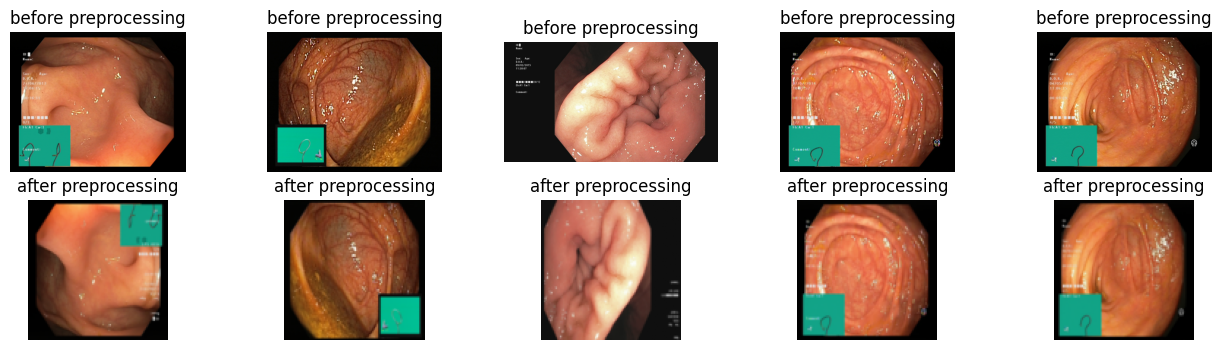

In [103]:
n_sample = 5
indices = np.random.choice(len(unprocessed_normal_ds),n_sample)
transform = get_transform()

plt.figure(figsize = (16,4))
for i in range(n_sample):
    img = unprocessed_normal_ds[indices[i]]
    plt.subplot(2,n_sample,i+1)
    plt.title('before preprocessing')
    plt.imshow(img)
    plt.axis('off')

    img = transform(img)
    plt.subplot(2,n_sample,i+1+n_sample)
    plt.title('after preprocessing')
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')


In [111]:
normal_path = 'processed/normal'
os.makedirs(normal_path, exist_ok=True)

polyps_path = 'processed/polyps'
os.makedirs(polyps_path, exist_ok=True)
envo_transforms = [get_transform(0,0),get_transform(0,1),get_transform(1,0),get_transform(1,1)]
img_num = 0

for idx in tqdm(range(len(processed_normal_ds)), total=len(processed_normal_ds)):
    image = unprocessed_normal_ds[idx]
    for transform in envo_transforms:
        img = transform(image)
        img = transforms.ToPILImage()(img)
        filename = f"{img_num}.jpg"
        img_num += 1
        img.save(os.path.join(normal_path, filename))

for idx, img in tqdm(enumerate(processed_polyps_ds), total=len(processed_polyps_ds)):
    img = transforms.ToPILImage()(img)
    filename = f"{idx}.jpg"
    img.save(os.path.join(polyps_path, filename))


100%|██████████| 500/500 [00:03<00:00, 126.33it/s]


In [112]:
transform = transforms.ToTensor()
normal_dataset = EndoDataset(root='processed/normal', transform=transform)
polyps_dataset = EndoDataset(root='processed/polyps', transform=transform)


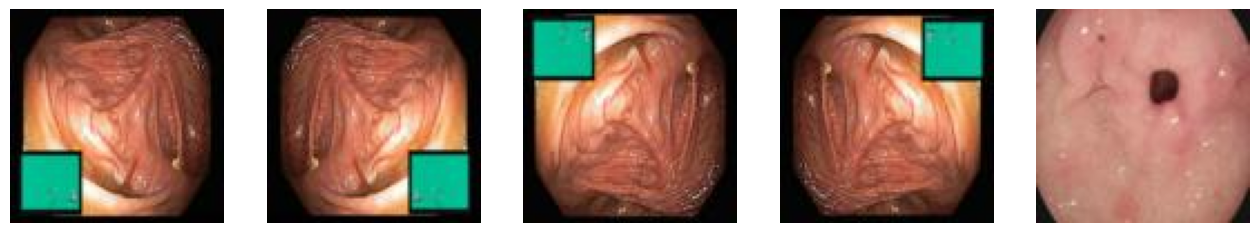

In [113]:
n_sample = 5
indices = np.arange(5)

plt.figure(figsize = (16,4))
for i in range(n_sample):
    image_file = f"{i}.jpg"
    image_path = os.path.join('processed/normal',image_file)
    image = Image.open(image_path).convert('RGB')
    
    plt.subplot(1,n_sample,i+1)
    plt.imshow(image)
    plt.axis('off')


# Create the model

In [114]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, num_units=256, latent_dim=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels,16,3,1,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,1,1),
            nn.ReLU(),
            nn.Conv2d(32,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.Conv2d(64,128,3,1,1),
            nn.ReLU(),
            nn.Conv2d(128,256,3,2,1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(36864,num_units),
            nn.ReLU(),
        )
        self.mu = nn.Linear(num_units,latent_dim)
        self.std = nn.Linear(num_units,latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        return self.mu(x),self.std(x)

summary(Encoder(3,256,6),(1,3,96,96))


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 6]                    --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Conv2d: 2-1                       [1, 16, 96, 96]           448
│    └─ReLU: 2-2                         [1, 16, 96, 96]           --
│    └─Conv2d: 2-3                       [1, 32, 96, 96]           4,640
│    └─ReLU: 2-4                         [1, 32, 96, 96]           --
│    └─Conv2d: 2-5                       [1, 32, 48, 48]           9,248
│    └─ReLU: 2-6                         [1, 32, 48, 48]           --
│    └─Conv2d: 2-7                       [1, 64, 24, 24]           18,496
│    └─ReLU: 2-8                         [1, 64, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 128, 24, 24]          73,856
│    └─ReLU: 2-10                        [1, 128, 24, 24]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 12]          295

In [115]:
class Decoder(nn.Module):
    def __init__(self, num_units=36864, latent_dim=6):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,num_units),
            nn.ReLU(),
            nn.Unflatten(1, (256, 12, 12)),
            nn.ConvTranspose2d(256,256,3,2,1,1),
            nn.ReLU(),
            nn.Conv2d(256,128,3,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3,2,1,1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,3,2,1,1),
            nn.ReLU(),
            nn.Conv2d(32,32,3,1,1),
            nn.ReLU(),
            nn.Conv2d(32,3,3,1,1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

summary(Decoder(),(1,6))


Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 3, 96, 96]            --
├─Sequential: 1-1                        [1, 3, 96, 96]            --
│    └─Linear: 2-1                       [1, 36864]                258,048
│    └─ReLU: 2-2                         [1, 36864]                --
│    └─Unflatten: 2-3                    [1, 256, 12, 12]          --
│    └─ConvTranspose2d: 2-4              [1, 256, 24, 24]          590,080
│    └─ReLU: 2-5                         [1, 256, 24, 24]          --
│    └─Conv2d: 2-6                       [1, 128, 24, 24]          295,040
│    └─ReLU: 2-7                         [1, 128, 24, 24]          --
│    └─ConvTranspose2d: 2-8              [1, 64, 48, 48]           73,792
│    └─ReLU: 2-9                         [1, 64, 48, 48]           --
│    └─Conv2d: 2-10                      [1, 64, 48, 48]           36,928
│    └─ReLU: 2-11                        [1, 64, 48, 48]      

In [116]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, enc_num_units=256, dec_num_units=36864, latent_dim=6):
        super().__init__()
        self.encoder = Encoder(in_channels,enc_num_units,latent_dim)
        self.decoder = Decoder(dec_num_units, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

summary(VAE(),(1,3,96,96))


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 96, 96]            --
├─Encoder: 1-1                           [1, 6]                    --
│    └─Sequential: 2-1                   [1, 256]                  --
│    │    └─Conv2d: 3-1                  [1, 16, 96, 96]           448
│    │    └─ReLU: 3-2                    [1, 16, 96, 96]           --
│    │    └─Conv2d: 3-3                  [1, 32, 96, 96]           4,640
│    │    └─ReLU: 3-4                    [1, 32, 96, 96]           --
│    │    └─Conv2d: 3-5                  [1, 32, 48, 48]           9,248
│    │    └─ReLU: 3-6                    [1, 32, 48, 48]           --
│    │    └─Conv2d: 3-7                  [1, 64, 24, 24]           18,496
│    │    └─ReLU: 3-8                    [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-9                  [1, 128, 24, 24]          73,856
│    │    └─ReLU: 3-10                   [1, 128, 24, 24]          --


In [117]:
def train_epoch(model, data_loader, criterion_kl, criterion_recon, optimizer, device):
  total_loss_kl = 0
  total_loss_recon = 0
  num_batches = len(data_loader)
  model.train()

  for images in data_loader:
    images = images.to(device)
    optimizer.zero_grad()
    outputs,mu,logvar = model(images)

    loss_kl = criterion_kl(mu, logvar)
    loss_recon = criterion_recon(outputs, images)
    loss = loss_kl + loss_recon

    loss.backward()
    optimizer.step()

    total_loss_kl += loss_kl.item()
    total_loss_recon += loss_recon.item()

  return total_loss_kl / num_batches, total_loss_recon / num_batches


In [137]:
def train(model, data_loader, criterion_kl, criterion_recon, optimizer, epochs, device):
  hist = {
      "kl_loss": [],
      "recon_loss": [],
      "total_loss": [],
  }

  model = model.to(device)
  model.train()
  for epoch in range(1, epochs + 1):
    kl_loss, recon_loss = train_epoch(model, data_loader, criterion_kl, criterion_recon, optimizer, device)
    hist['kl_loss'].append(kl_loss)
    hist['recon_loss'].append(recon_loss)
    hist['total_loss'].append(kl_loss+recon_loss)
    if epoch % 50 == 0:
      print(f"Epoch [{epoch}] Average KL Loss: {kl_loss:.6f} Average Reconstruction Loss: {recon_loss:.6f} Total Average Loss: {(kl_loss+recon_loss):.6f}")
  return hist


In [138]:
def plot_history(history, steps=1):
    epochs = len(history['kl_loss'])
    plt.plot(range(1,epochs*steps+steps), history['kl_loss'])
    plt.plot(range(1,epochs*steps+steps), history['recon_loss'])
    plt.plot(range(1,epochs*steps+steps), history['total_loss'])
    plt.title('Losses of model')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['KL Divergence Loss', 'Reconstruction Loss', 'Total Loss'])
    plt.ylim(0, max(max(history['kl_loss']),max(history['recon_loss']))*1.05)
    plt.show()


# Train the models

In [120]:
batch_size=128
normal_loader = DataLoader(normal_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Epoch [50] Average KL Loss: 2477.272409 Average Reconstruction Loss: 25050.153757 Total Average Loss: 27527.426166
Epoch [100] Average KL Loss: 2494.950590 Average Reconstruction Loss: 22340.360372 Total Average Loss: 24835.310962
Epoch [150] Average KL Loss: 2528.920457 Average Reconstruction Loss: 19894.262675 Total Average Loss: 22423.183131
Epoch [200] Average KL Loss: 2594.092997 Average Reconstruction Loss: 17516.393513 Total Average Loss: 20110.486510
Epoch [250] Average KL Loss: 2645.299924 Average Reconstruction Loss: 14877.877015 Total Average Loss: 17523.176940
Epoch [300] Average KL Loss: 2675.762888 Average Reconstruction Loss: 13946.987118 Total Average Loss: 16622.750005
Epoch [350] Average KL Loss: 2694.931677 Average Reconstruction Loss: 12487.268617 Total Average Loss: 15182.200294
Epoch [400] Average KL Loss: 2702.416753 Average Reconstruction Loss: 11290.481279 Total Average Loss: 13992.898032
Epoch [450] Average KL Loss: 2722.285920 Average Reconstruction Loss: 106

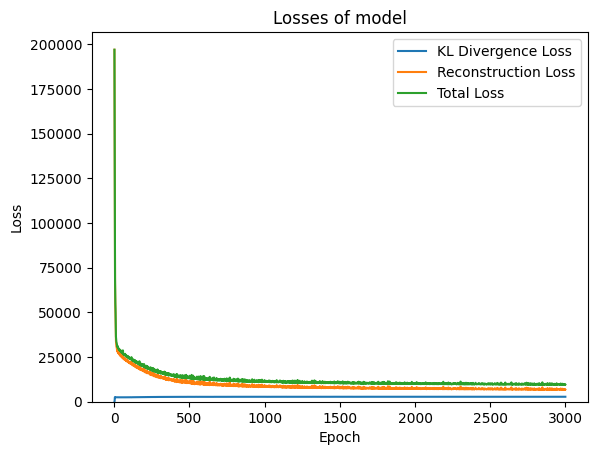

In [140]:
epochs = 3000
lr = 1e-3

model_mse = VAE()
optimizer = torch.optim.Adam(model_mse.parameters(), lr=lr)

criterion_kl = lambda mu,logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
criterion_mse = nn.MSELoss(reduction='sum')

hist = train(model_mse, normal_loader, criterion_kl, criterion_mse, optimizer, epochs, device)

state_dict = model_mse.state_dict()
torch.save(state_dict, 'vae_mse.pth')

plot_history(hist)


Epoch [50] Average KL Loss: 2990.575247 Average Reconstruction Loss: 1944474.180851 Total Average Loss: 1947464.756098
Epoch [100] Average KL Loss: 2976.467145 Average Reconstruction Loss: 1934859.146277 Total Average Loss: 1937835.613422
Epoch [150] Average KL Loss: 3026.786361 Average Reconstruction Loss: 1927845.093085 Total Average Loss: 1930871.879446
Epoch [200] Average KL Loss: 3068.325034 Average Reconstruction Loss: 1924540.965426 Total Average Loss: 1927609.290460
Epoch [250] Average KL Loss: 3122.264124 Average Reconstruction Loss: 1916961.526596 Total Average Loss: 1920083.790720
Epoch [300] Average KL Loss: 3155.301249 Average Reconstruction Loss: 1916066.010638 Total Average Loss: 1919221.311887
Epoch [350] Average KL Loss: 3170.746172 Average Reconstruction Loss: 1909745.050532 Total Average Loss: 1912915.796704
Epoch [400] Average KL Loss: 3191.337397 Average Reconstruction Loss: 1908905.726064 Total Average Loss: 1912097.063461
Epoch [450] Average KL Loss: 3206.425838 

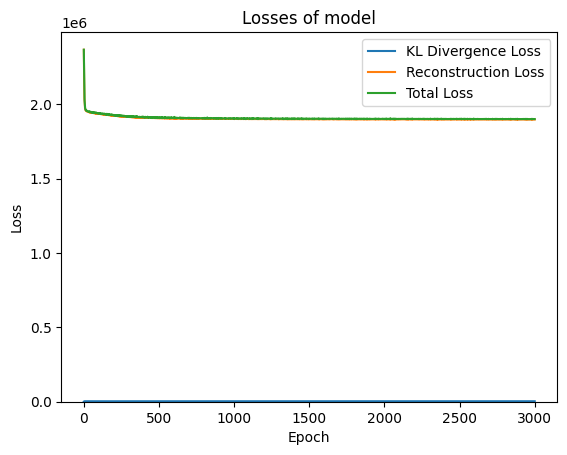

In [139]:
epochs = 3000
lr = 1e-3

model_bce = VAE()
optimizer = torch.optim.Adam(model_bce.parameters(), lr=lr)

criterion_kl = lambda mu,logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
criterion_bce = nn.BCELoss(reduction='sum')

hist = train(model_bce, normal_loader, criterion_kl, criterion_bce, optimizer, epochs, device)

state_dict = model_bce.state_dict()
torch.save(state_dict, 'vae_bce.pth')

plot_history(hist)


# Evaluation

## Qualitative

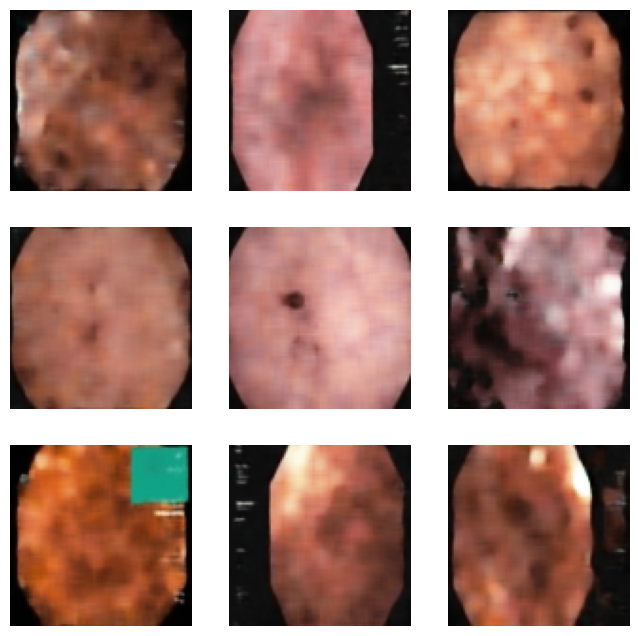

In [141]:
model_mse.eval()
noises = torch.randn((9,6)).to(device)
images = model_mse.get_decoder()(noises)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

post_process = lambda img: img.cpu().permute(1, 2, 0).detach().numpy()

for i, ax in enumerate(axes.flat):
    ax.imshow(post_process(images[i]))
    ax.axis('off')


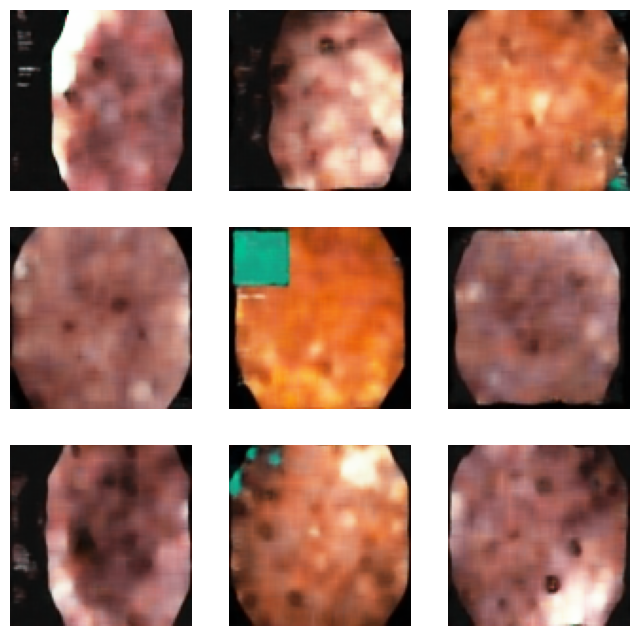

In [142]:
model_bce.eval()
noises = torch.randn((9,6)).to(device)
images = model_bce.get_decoder()(noises)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
post_process = lambda img: img.cpu().permute(1, 2, 0).detach().numpy()

for i, ax in enumerate(axes.flat):
    ax.imshow(post_process(images[i]))
    ax.axis('off')


In [146]:
polyps_loader = DataLoader(polyps_dataset, batch_size=5, shuffle=True, num_workers=2)
dataiter = iter(polyps_loader)


In [284]:
normal_loader = DataLoader(normal_dataset, batch_size=5, shuffle=True, num_workers=2)
dataiter = iter(normal_loader)


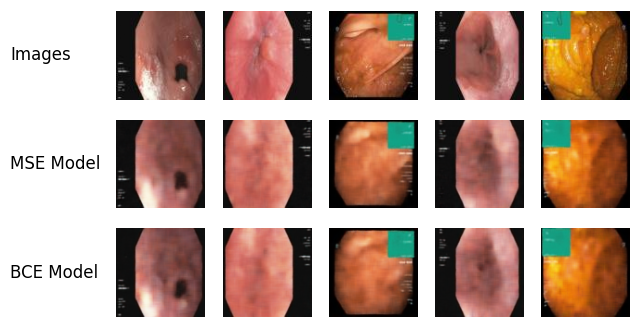

In [285]:
images = next(dataiter)
images = images.to(device)
outputs_mse = model_mse(images)
outputs_bce = model_bce(images)
n_sample = 6
fig, axes = plt.subplots(3, 6, figsize=(8, 4))

texts = ['Images','MSE Model','BCE Model']
for i,text in enumerate(texts):
    axes[i][0].text(0, 0.5, text, fontsize=12, verticalalignment='center')
    axes[i][0].axis('off')

for i in range(1,n_sample):
    axes[0][i].imshow(post_process(images[i-1]))
    axes[0][i].axis('off')

    axes[1][i].imshow(post_process(outputs_mse[0][i-1]))
    axes[1][i].axis('off')

    axes[2][i].imshow(post_process(outputs_bce[0][i-1]))
    axes[2][i].axis('off')


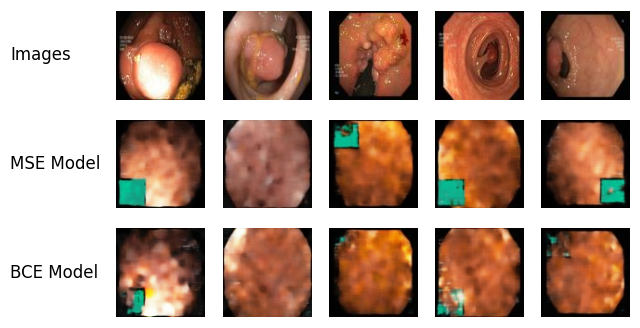

In [148]:
images = next(dataiter)
images = images.to(device)
outputs_mse = model_mse(images)
outputs_bce = model_bce(images)
n_sample = 6
fig, axes = plt.subplots(3, 6, figsize=(8, 4))

texts = ['Images','MSE Model','BCE Model']
for i,text in enumerate(texts):
    axes[i][0].text(0, 0.5, text, fontsize=12, verticalalignment='center')
    axes[i][0].axis('off')

for i in range(1,n_sample):
    axes[0][i].imshow(post_process(images[i-1]))
    axes[0][i].axis('off')

    axes[1][i].imshow(post_process(outputs_mse[0][i-1]))
    axes[1][i].axis('off')

    axes[2][i].imshow(post_process(outputs_bce[0][i-1]))
    axes[2][i].axis('off')


## Quantitative

In [149]:
polyps_loader = DataLoader(polyps_dataset, batch_size=50, shuffle=True, num_workers=2)
dataiter = iter(polyps_loader)


In [150]:
images = next(dataiter)
images = images.to(device)
outputs,mu,logvar = model_mse(images)

scores = defaultdict(lambda: defaultdict(float))

psnr = PeakSignalNoiseRatio(data_range=1.0,reduction="none",dim=(1,2,3))
psnrs = psnr(outputs, images).to(device)

scores["Mean"]["PSNR"] = psnrs.mean().item()
scores["Standard Deviation"]["PSNR"] = psnrs.std().item()

ssim = StructuralSimilarityIndexMeasure(data_range=1.0,reduction="none")
ssims = ssim(outputs, images).to(device)

scores["Mean"]["SSIM"] = ssims.mean().item()
scores["Standard Deviation"]["SSIM"] = ssims.std().item()

pd.DataFrame(scores)


,Mean,Standard Deviation
PSNR,16.952047,2.294434
SSIM,0.470127,0.084576


In [151]:
images = next(dataiter)
images = images.to(device)
outputs,mu,logvar = model_bce(images)

scores = defaultdict(lambda: defaultdict(float))

psnr = PeakSignalNoiseRatio(data_range=1.0,reduction="none",dim=(1,2,3))
psnrs = psnr(outputs, images).to(device)

scores["Mean"]["PSNR"] = psnrs.mean().item()
scores["Standard Deviation"]["PSNR"] = psnrs.std().item()

ssim = StructuralSimilarityIndexMeasure(data_range=1.0,reduction="none")
ssims = ssim(outputs, images).to(device)

scores["Mean"]["SSIM"] = ssims.mean().item()
scores["Standard Deviation"]["SSIM"] = ssims.std().item()

pd.DataFrame(scores)


,Mean,Standard Deviation
PSNR,16.584135,2.276679
SSIM,0.447347,0.093633


# Create a Classifier

In [235]:
class Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        in_features = self.model.fc.in_features
        
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

summary(Classifier(),(1,3,96,96))


Layer (type:depth-idx)                        Output Shape              Param #
Classifier                                    [1, 2]                    --
├─ResNet: 1-1                                 [1, 2]                    --
│    └─Conv2d: 2-1                            [1, 64, 48, 48]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 48, 48]           (128)
│    └─ReLU: 2-3                              [1, 64, 48, 48]           --
│    └─MaxPool2d: 2-4                         [1, 64, 24, 24]           --
│    └─Sequential: 2-5                        [1, 64, 24, 24]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 24, 24]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 24, 24]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 12, 12]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 12, 12]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 12, 12]      

# Train the classifier

In [271]:
def train_classifier(model, data_loader, criterion, optimizer, epochs, device):
  model.train()
  model = model.to(device)
  for epoch in range(1, epochs + 1):
    num_batches = len(data_loader)
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [272]:
num_images=300
polyps_loader = DataLoader(polyps_dataset, batch_size=num_images, shuffle=True, num_workers=2)


In [273]:
real_imgs = []
fake_imgs = []
model_mse.eval()
for images in polyps_loader:
    with torch.no_grad():
        images = images.to(device)
        outputs,_,_ = model_mse(images)
    real_imgs = images
    break
fake_imgs = outputs


In [274]:
real_labels = torch.ones(num_images, dtype=torch.long)
fake_labels = torch.zeros(num_images, dtype=torch.long)

real_dataset = TensorDataset(real_imgs, real_labels)
fake_dataset = TensorDataset(fake_imgs, fake_labels)

num_train = 200
indices = np.random.permutation(num_images)
train_indices = indices[:num_train]
test_indices = indices[num_train:]

real_train_ds = Subset(real_dataset,train_indices)
real_test_ds = Subset(real_dataset,test_indices)

fake_train_ds = Subset(fake_dataset,train_indices)
fake_test_ds = Subset(fake_dataset,test_indices)

batch_size = 128
combined_train_ds = ConcatDataset([real_train_ds, fake_train_ds])
indices = np.random.permutation(len(combined_train_ds))
combined_train_ds = Subset(combined_train_ds, indices)
train_loader_mse = DataLoader(combined_train_ds, batch_size=batch_size, shuffle=True)

combined_test_ds = ConcatDataset([real_test_ds, fake_test_ds])
indices = np.random.permutation(len(combined_test_ds))
combined_test_ds = Subset(combined_test_ds, indices)
test_loader_mse = DataLoader(combined_test_ds, batch_size=batch_size, shuffle=False)


In [275]:
epochs = 30
lr = 1e-2

classifier_mse = Classifier()
optimizer = torch.optim.Adam(classifier_mse.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(reduction='sum')

train_classifier(classifier_mse, train_loader_mse, criterion, optimizer, epochs, device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [276]:
real_imgs = []
fake_imgs = []
model_bce.eval()
for images in polyps_loader:
    with torch.no_grad():
        images = images.to(device)
        outputs,_,_ = model_bce(images)
    real_imgs = images
    break
fake_imgs = outputs


In [277]:
real_labels = torch.ones(num_images, dtype=torch.long)
fake_labels = torch.zeros(num_images, dtype=torch.long)

real_dataset = TensorDataset(real_imgs, real_labels)
fake_dataset = TensorDataset(fake_imgs, fake_labels)

num_train = 200
indices = np.random.permutation(num_images)
train_indices = indices[:num_train]
test_indices = indices[num_train:]

real_train_ds = Subset(real_dataset,train_indices)
real_test_ds = Subset(real_dataset,test_indices)

fake_train_ds = Subset(fake_dataset,train_indices)
fake_test_ds = Subset(fake_dataset,test_indices)

batch_size = 128
combined_train_ds = ConcatDataset([real_train_ds, fake_train_ds])
indices = np.random.permutation(len(combined_train_ds))
combined_train_ds = Subset(combined_train_ds, indices)
train_loader_bce = DataLoader(combined_train_ds, batch_size=batch_size, shuffle=True)

combined_test_ds = ConcatDataset([real_test_ds, fake_test_ds])
indices = np.random.permutation(len(combined_test_ds))
combined_test_ds = Subset(combined_test_ds, indices)
test_loader_bce = DataLoader(combined_test_ds, batch_size=batch_size, shuffle=False)


In [278]:
epochs = 30
lr = 1e-2

classifier_bce = Classifier()
optimizer = torch.optim.Adam(classifier_bce.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_classifier(classifier_bce, train_loader_bce, criterion, optimizer, epochs, device)


# Evaluate the classifier

In [279]:
def evaluate(predictions, actual_values,model_names):
    scores = defaultdict(lambda: defaultdict(float))
    for i, name in enumerate(model_names):
        scores[name]["Accuracy"] = accuracy_score(actual_values[i], predictions[i] > 0.5)
        scores[name]["AUC"] = roc_auc_score(actual_values[i], predictions[i])

    return pd.DataFrame(scores)


In [280]:
def get_predictions(model, data_loader, device):
    y_pred = []
    y_true = []
    model = model.to(device)
    model.eval()

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            y_pred.append(probs.cpu().numpy())

        y_true.append(labels.cpu().numpy())

    y_true = np.concatenate(y_true, axis=0).flatten()
    y_pred = np.concatenate(y_pred, axis=0).flatten()
    return y_pred, y_true


In [281]:
y_pred = []
y_true = []
model_names = ['Classifier for MSE VAE','Classifier for BCE VAE']

pred, true = get_predictions(classifier_mse,test_loader_mse,device)
y_pred.append(pred)
y_true.append(true)

pred, true = get_predictions(classifier_bce,test_loader_bce,device)
y_pred.append(pred)
y_true.append(true)

scores = evaluate(y_pred,y_true,model_names)
scores


,Classifier for MSE VAE,Classifier for BCE VAE
Accuracy,0.995,1.0
AUC,1.000,1.0
